In [1]:
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import time

%matplotlib inline

# Helper Functions for running simulations and getting data.

In [2]:
def getDataDT(f, g, u, x0, n=2, tol=1e4):
    """ Generate a single system trajectory for a system with:
        x[k+1] = f(x[k], u[k])
        y[k] = g(x[k], u[k])
         for all k=0,1,...,len(u), and with x[0]=x0. 
        Then return that trajectory: (u[i], y[i]) for all i=0,1,...,len(u)
         as a 2d numpy array. 
        For this function, u is an array, potentially 2D.
    """
    x = x0
    out = np.zeros([len(u), n * len(u[0]) + n * len(g(x0, u[0]))])
    outprev = []
    for k in range(len(u)):
        y = g(x, u[k])
        x = f(x, u[k])
        if np.sum(np.abs(y)) > tol or np.sum(np.abs(x)) > tol:
            return out
        if k >= n - 1:
            out[k] = np.hstack([outprev[k - i] for i in range(n - 1, 0, -1)] + [u[k], y])
        outprev.append(np.hstack([u[k], y]))
    return out


def generate_inputs(n_inputs, times, multiplicity=7, mag=1.0, squigg=2.0):
    """
    Makes multisinusoidal inputs for system ID purposes. At the end of these inputs zero inputs
        are appended. This way we can see some unforced behavior from the system as well.
    @param n_inputs: int, the number of inputs.
    @param times: 1d array, the times to generate the inputs for.
    @param multiplicity: int, the number of sines in the summed multisine.
    @param mag: float, a factor that we scale our inputs by
    @param squigg: float, how squiggly we want the inputs to be (frequency is multiplied by this constant)
    """
    us = []
    for i in range(n_inputs):
        u = []
        rand = np.sqrt(i+1)#np.abs(np.random.randn())
        rand_shift = np.sqrt(n_inputs - i)
        for t in times:
            u.append(mag / multiplicity * np.sqrt(n_inputs - i) * np.sum([np.sin(np.sqrt((m + 1) * rand) * t * squigg - rand_shift) for m in range(multiplicity)]))
        for t in range(len(times) // 3):
            u.append(0)
        us.append(u)
    out = np.array(us)
    np.random.shuffle(out)
    return out



def train_dataDT(f, g, x0=np.array([0,0]), nInputs=2, maxMult=6, 
                  numIntervals=20, inputMag=1.0, inputSquigg=2.0, n=2):
    """ 
    Get's data for training!
    """
    data = []
    times = np.linspace(0, 1, numIntervals)
    for m in range(maxMult):
        u = generate_inputs(nInputs, times, m + 1, inputMag, inputSquigg)
        newData = getDataDT(f, g, u.transpose(), x0 + np.random.randn(np.shape(x0)[0]), n)
        data.append(newData)
    newData = getDataDT(f, g, np.zeros(np.shape(u.transpose())), x0, n)
    data.append(newData)
    return np.vstack(data)



# The Neural Network Used to Learn the Koopman Operator

In [3]:
class Feedforward(nn.Module):
    """
    This class is a feedforward neural network.
    """
    def __init__(self, n_layers, layer_width, dim_in, dim_added, activation=nn.ReLU6):
        nn.Module.__init__(self)
        self.activation = activation()
        layers = []
        layers.append(nn.Linear(dim_in, layer_width))
        for i in range(n_layers):
            layers.append(nn.Linear(layer_width, layer_width))
            layers.append(self.activation)
        layers.append(nn.Linear(layer_width, dim_in + dim_added))
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class StateLiftingMap(nn.Module):
    """
    This class is 2 parallel feedforward neural networks that output the lifting, then a 
    linear operator is applied to each lifting (note bias=False) and they are summed to 
    get an approximate for the lifting one step in the future (or, if you have the information
    or an approximation to the information, it can instead be trying to compute the time
    derivative of the lifting).
    """
    def __init__(self, n_layers, layer_width, dim_y, dim_u, dim_added_y):
        nn.Module.__init__(self)
        self.feedforward_y = Feedforward(n_layers, layer_width, dim_y, dim_added_y)
        self.linear_y = nn.Linear(dim_y * 2 + dim_added_y, dim_y * 2 + dim_added_y, bias=False)
        self.linear_u = nn.Linear(dim_u, dim_y * 2 + dim_added_y, bias=False)
        self.dimState = dim_y * 2 + dim_added_y
        self.dimInput = dim_u 
        self.dim_y = dim_y
        self.dim_u = dim_u
    
    def forward(self, y, u):
        y2 = self.feedforward_y(y)
        sai_y = torch.cat([y, y2], dim=1)
        sai_y2y = self.linear_y(sai_y)
        u2y = self.linear_u(u)
        #sai_u2y = torch.cat([u2y, torch.zeros(u2y.size()[0], self.dimState - self.dim_y)], dim=1)
        y_next_approx = sai_y2y + u2y#sai_u2y
        return y_next_approx
    
    def lift(self, y, u):
        y2 = self.feedforward_y(y)
        sai_y = torch.cat([y, y2], dim=1)
        return sai_y, u
    
    def koopmanOperate(self, sai_y, u):
        sai_y2y = self.linear_y(sai_y)
        u2y = self.linear_u(u)
        #sai_u2y = torch.cat([u2y, torch.zeros(u2y.size()[0], self.dimState - self.dim_y)], dim=1)
        y_next_approx = sai_y2y + u2y#sai_u2y
        return y_next_approx
    
    def getKoopmanOperator(self):
        Kyy, Kyu = np.zeros([self.dimState, self.dimState]), np.zeros([self.dimState, self.dimInput])
        for i, param in enumerate(self.linear_y.parameters()): # There is just one parameter, it is the Matrix of weights
            Kyy[:] = param[:].detach().numpy()
        for i, param in enumerate(self.linear_u.parameters()): # There is just one parameter, it is the Matrix of weights
            Kyu[:, :] = param[:].detach().numpy()#Kyu[:self.dim_y, :] = param[:].detach().numpy()
        return Kyy, Kyu
        


# Function to do the system ID.

In [4]:
# GLOBAL VARIABLES
n_epochs = 401
n_outs = 2
n_ins = 1
added_out_dims = 6
added_in_dims = 19
n_layers = 4
layer_size = 20
minibatch_size = 50
# end GLOBAL VARIABLES

# Function to train the neural network.
def train(system):
    """
    """
    loss = nn.MSELoss()
    koop_net = StateLiftingMap(n_layers, layer_size, n_outs, n_ins, added_in_dims)
    opt = torch.optim.Adam(koop_net.parameters(), lr=0.00015, weight_decay=0.0001)
    lamb = .0001
    identity = lambda x, u: x
    nInputs, nOutputs, nTot, nTotPIn, nTot2 = 1, 2, 3, 4, 6
    train_data = train_dataDT(system, identity, x0=np.array([0., 0.]), maxMult=100, nInputs=1, n=2) # For system ID how much and what type of data is nessisary?
    print("below we print our loss as the neural network trains.")
    for epoch in range(n_epochs):
        start = time.time()
        np.random.shuffle(train_data)
        num_minibatches = len(train_data) // minibatch_size
        minibatches = [train_data[i * minibatch_size: (i + 1) * minibatch_size] for i in range(num_minibatches)]
        for datapoint in minibatches:
            datapoint = torch.tensor(datapoint).float()
            opt.zero_grad()
            # put the right part of the datapoint into the neural network
            liftedAftr = koop_net.lift(datapoint[:, nTotPIn:nTot2], datapoint[:, nTot:nTotPIn])[0] 
            koop_approx = koop_net(datapoint[:, nInputs:nTot], datapoint[:, 0:nInputs]) 
            #print(koop_approx, liftedAftr)
            error = loss(koop_approx, liftedAftr) + lamb * torch.norm(torch.cat([x.view(-1) for x in koop_net.parameters()]), 1)
            #print(error)
            error.backward()
            opt.step()
        if epoch % 50 == 0:
            print(epoch, error, 120 * (time.time() - start))
    torch.save(koop_net.state_dict(), "DT_network.pth")
    print("We finished training our neural network!")
    return koop_net


In [5]:
# Validation function.

# set initial conditions and inputs (GLOBAL VARIABLES)
coeff = .4
us = np.array([[[coeff*np.sin(i)]] for i in range(15)])
x0 = np.array([[-.5, .5]])
A = np.array([[0, 1], [-0.419974342, -0.419974342]]) # This matches our test system
B = np.array([[0], [1]]) # This matches our test system
identity = lambda x, u: x
# end GLOBAL VARIABLES

def validate(system, koop_net):
    x_lin = x0[0]
    linearized_outs = [x_lin]
    for i in range(15):
        x_lin = A @ x_lin + B @ us[i, 0, :]
        linearized_outs.append(x_lin)
    linearized_outs = np.array(linearized_outs)

    # Learned system simulation
    pred_data = [x0[0]]
    state = torch.tensor(x0)
    inputs = torch.tensor(us)
    for i in range(len(us)):
        #print(state, inputs[i])
        state = koop_net(state.float(), inputs[i].float())[:,0:2]
        pred_data.append(state[0].detach().numpy())
    pred_data = np.array(pred_data)


    # simulate system
    data = getDataDT(system, identity, us[:, 0, :], x0[0])[:, 1:3]
    #print(np.shape(data))
    plt.plot(data[1:14, 0], "brown", linewidth=1, label="x1")
    plt.plot(data[1:14, 1], "darkblue", linewidth=1, label="x2")
    plt.plot(linearized_outs[:13, 0], "r", linestyle=":", linewidth=2, label="linearized x1")
    plt.plot(linearized_outs[:13, 1], "b", linestyle=":", linewidth=2, label="linearized x2")
    plt.plot(pred_data[0:13, 0], "tomato", linestyle="--", linewidth=2, label="Koopman x1")
    plt.plot(pred_data[0:13, 1], "dodgerblue", linestyle="--", linewidth=2, label="Koopman x2")
    plt.xlabel("Time")
    plt.ylabel("State Value")
    plt.legend()
    plt.title("Evolution of Learned System vs Actual for Hyp")
    plt.show()

# Demonstration of the technique on a simple system.
# Training and basic validation.

below we print our loss as the neural network trains.
0 tensor(0.1357, grad_fn=<AddBackward0>) 18.48764419555664
50 tensor(0.0193, grad_fn=<AddBackward0>) 17.48159408569336
100 tensor(0.0132, grad_fn=<AddBackward0>) 21.188364028930664
150 tensor(0.0129, grad_fn=<AddBackward0>) 20.98151206970215
200 tensor(0.0088, grad_fn=<AddBackward0>) 17.323808670043945
250 tensor(0.0050, grad_fn=<AddBackward0>) 20.005817413330078
300 tensor(0.0054, grad_fn=<AddBackward0>) 16.699447631835938
350 tensor(0.0041, grad_fn=<AddBackward0>) 16.742048263549805
400 tensor(0.0035, grad_fn=<AddBackward0>) 36.20112419128418
We finished training our neural network!


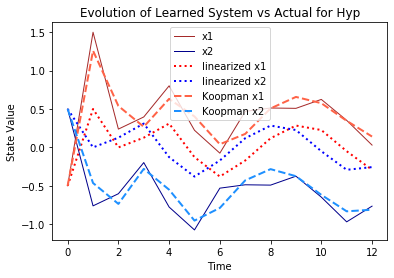

In [6]:

def NC3_8Mod(x, u): # Initially meant to be CT
    """
    Nonlineaer system (taken from our Kalil textbook, Nonlinear Control,
    chapter 3 problem 8, and adapted to discrete-time and slightly modified)
    used to demonstrate this technique.
    """
    x1, x2 = x
    return x2 + 1, -np.tanh(x1 + x2 + 1) + u[0]

koop_net = train(NC3_8Mod)
validate(NC3_8Mod, koop_net)